<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/SL_Policy_Training_%E7%A2%BA%E8%AA%8D%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/OTHELLO

/content/drive/MyDrive/OTHELLO


In [ ]:
import pandas as pd
import gc
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from tqdm.notebook import tqdm
import copy
from torch.utils.data import Dataset, DataLoader
import torch

from torch.nn import Conv2d, Linear, ReLU, Dropout
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import KFold

from torch.optim import Adam
from sklearn.metrics import accuracy_score

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(77)

# Datset

In [ ]:
#DEBUG = True

#data = pd.read_csv('Othello_Kihu.txt', header=None, sep=' ')
#data = data[data[64]!=0] #石を置けない場合(0, 0)のactionをとるが、データ数が１だけなので除外する
#data.iloc[:, :64] = data.iloc[:, :64].where( data.iloc[:, :64] != 2, -1) # 黒 : -1, 白 : 1, 何もなし : 0　の 8*8 の盤面を持つ　ようにする
#cols = [ i for i in range(64)]
#data.loc[data[66]=='B', cols] = data.loc[data[66]=='B', cols]*-1 # 黒手番の場合、自分と相手を入れ替える　モデルが理解しやすいように
#data = data.drop_duplicates()
#data.to_csv('drop_dups.csv', index=False)
#
#if DEBUG:
#    data = data.sample(n=10000)

data = pd.read_csv('drop_dups.csv')
gc.collect()

print(data.shape)
data.head()

(3356857, 68)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,3,W,59
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5,W,57
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,6,W,55
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,W,53
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,-1,0,0,0,0,-1,-1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,-1,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,3,W,51


In [ ]:
# 盤面を渡すと、今回置ける場所を返してくれる
# 0が置いてない場所、1が自分の意思がある場所、-1が相手の石が置いてある場所

def check(board): #今回の手番の人が打てる場所をリストアップする
    okeru_list = []
    for x in range(8):
        for y in range(8):
            plc = board[y, x]
            if plc == 0: #もし今回のplaceに何も置いていなければ8方向探索する
                able = octpass([x,y], board) #今回の場所に置いたときひっくり返せる場所をリストアップする
                if len(able) > 0: #もしひっくり返せる場所が0ではないなら置ける場所リストに今回の場所を追加する
                    okeru_list.append([x,y])
    return okeru_list
  
def octpass(basho, board): #今回置きたい場所を渡したら８方向探索するメソッド
    basho_list = set() #今回ひっくり返せる場所のリスト(setクラスを使う→重複なしで扱える)

    if board[basho[1], basho[0]] != 0:
        print('既に石が置かれています')
    else:
        for x in [-1,0,1]:
            for y in [-1,0,1]: #8方向を順に見ていく
                tmp = [] #今回の確認する方向でひっくり返そうな場所を一時的に記憶しておくリスト

                if x == 0 and y == 0:
                    pass #方向がないときはパスする

                for length in range(1,9): #今回確認する方向にだんだん腕を伸ばしていく
                    if 0<=basho[1]+y*length<=7 and 0<=basho[0]+x*length<=7: #腕が盤面に収まるのなら
                        check_plc = board[basho[1]+y*length, basho[0]+x*length]
                        if check_plc == 0: #もし確認した場所に何も置いていなければ、飛び石になっちゃうので手を伸ばすのを終了
                            break
                        elif check_plc == -1: #もし確認した場所が相手プレイヤーの石だった場合その場所を一時記憶しておく
                            tmp.append( (basho[0]+x*length, basho[1]+y*length) )
                        elif check_plc == 1: #もし確認した場所が自分の石だった場合、ひっくり返せるリストに現在ひっくり返せそうな場所を追加して腕を伸ばすのをやめる
                            if len(tmp) > 0: #中身がからでない場合のみ
                                basho_list |= set(tmp)
                            break #手を伸ばすのを終了
    
                    else: #もし盤面を飛び出してしまうならpassする
                        pass
    return list(basho_list)

In [ ]:
class OCDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.States = df.iloc[:, :64] #盤面
        self.player = df.iloc[:, 66] #W or B
        self.action = 8*(df.iloc[:, 65]-1) + (df.iloc[:, 64]-1) #0-63のどこに置くか

    def __len__(self):
        return self.States.shape[0]

    def __getitem__(self, idx):
        state_can = np.zeros((8,8))
        state = self.States.iloc[idx].values.reshape(8,8)
        puttables = check(state)
        #for puttable_place in puttables:
        #    state_can[puttable_place[0], puttable_place[1]] = 1 # 現在の手番が石を置ける場所

        state_my = (state == 1).astype(np.uint8) #自分の石の位置
        state_op = (state == -1).astype(np.uint8) #相手の石の位置
        state_on = (state != 0).astype(np.uint8)   # 盤面の石の位置
        states = np.stack( [state_on, state_op, state_my] )

        states = torch.tensor( states, dtype=torch.float32 )
        action = torch.tensor( self.action.iloc[idx], dtype=torch.int64 )

        return states, action, self.player.iloc[idx]

# Check Dataset

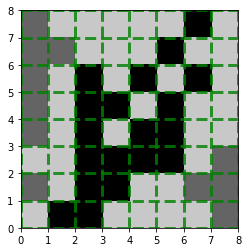

answer : [7, 0]
毎回黒手番です
[[0, 1], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [1, 6], [6, 1], [7, 0], [7, 1], [7, 2]]


In [ ]:
A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
states[0]

opp = (states[0][1]==1).detach().numpy().astype(np.uint8)*-1
my  = (states[0][2]==1).detach().numpy().astype(np.uint8)
table = opp + my

#table = data.iloc[idx, :64].values.reshape(8,8)
#actions = data.iloc[idx, [64, 65]]
#color = data.iloc[idx, 66]

def plt_img(state):
    A = np.flip(state, axis=0)
    table = np.stack([A, A, A]).transpose(1,2,0).astype(np.int16)

    plt.close()
    #plt.imshow((-3*table**2+7*table)*100+100, extent=(0,8,0,8), cmap='bwr')
    plt.imshow((table)*-100+100, extent=(0,8,0,8), cmap='bwr')
    plt.xticks([0,1,2,3,4,5,6,7,8])
    # x軸に補助目盛線を設定
    plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
            linestyle = "--", linewidth = 3)

    # y軸に目盛線を設定
    plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
            linestyle = "--", linewidth = 3)
    plt.show()

plt_img(table)

action = action[0].detach().numpy()
basho = [action%8, action//8]

print("answer :", basho)
#print(color)
print('毎回黒手番です')
print(check(table))

A = OCDataset(data)
B = DataLoader(
    dataset = A,
    batch_size=3,
    shuffle=True
)
states, action, color = iter(B).next()
#print(states[0])

plt.imshow( states[0].numpy().transpose(1,2,0) ,extent=(0,8,0,8), cmap='bwr')
plt.xticks([0,1,2,3,4,5,6,7,8])
# x軸に補助目盛線を設定
plt.grid(which = "major", axis = "x", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)

# y軸に目盛線を設定
plt.grid(which = "major", axis = "y", color = "green", alpha = 0.8,
        linestyle = "--", linewidth = 3)
print(action[0])
print( "y :",action[0]//8 +1 )
print( "x :",action[0]%8 +1 )
print(color[0]) 
print('常に緑の手番ということになってます')
print('赤が今回緑の人が置ける場所')

# Model

In [ ]:
class CNN_Brain(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.drop1 = nn.Dropout(p=0.3)
        self.drop2 = nn.Dropout(p=0.3)
        self.drop3 = nn.Dropout(p=0.3)
        self.drop4 = nn.Dropout(p=0.3)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*8*8, 64)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.drop1(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.drop2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.drop3(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.drop4(x)
        x = self.fc1(x)
        return x

# Training

In [ ]:
BATCH_SIZE = 256

def get_folds(NUM_FOLDS=5):
    kfold = KFold(n_splits=NUM_FOLDS, shuffle=True)
    folds = np.ones(data.shape[0])

    for i, (trn_idx, val_idx) in enumerate(kfold.split(data)):
        folds[val_idx] = i
    return folds

def get_loaders(df, folds, n_fold):
    trn_df = df[(folds!=n_fold)]
    val_df = df[(folds==n_fold)]

    trn_dataset = OCDataset(trn_df)
    val_dataset = OCDataset(val_df)

    trn_loader = DataLoader(
        dataset = trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    val_loader = DataLoader(
        dataset = val_dataset,
        batch_size = BATCH_SIZE,
        shuffle=False
    )
    return trn_loader, val_loader

#folds = get_folds(NUM_FOLDS=5)
#trn_loader, val_loader = get_loaders(data, folds, 0)

In [ ]:
def train_fn(model, optim, trn_loader, metrics):
    train_loss = 0
    accs = []
    #for table, action, _ in tqdm(trn_loader):
    for table, action, _ in trn_loader:
        model.train()
        optim.zero_grad()
        table   = table.to(DEVICE)
        action = action.to(DEVICE)
        pred = model(table)
        loss  = metrics(pred, action)
        loss.backward()
        optim.step()

        train_loss += loss.cpu().detach().numpy()
        acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pred.cpu().detach().numpy(), axis=1  ))
        accs.append(acc)
    return train_loss / len(trn_loader), np.mean(accs)

def valid_fn(model, val_loader, metrics):
    valid_loss = 0
    accs = []
    #for table, action, _ in  tqdm(val_loader):
    for table, action, _ in  val_loader:
        with torch.no_grad():
            model.eval()
            table = table.to(DEVICE)
            action = action.to(DEVICE)
            pred = model(table)
            loss  = metrics(pred, action)

            acc  = accuracy_score(action.cpu().detach().numpy(), np.argmax(pred.cpu().detach().numpy(), axis=1  ))
            valid_loss += loss.cpu().detach().numpy()
            accs.append(acc)
    return valid_loss/len(val_loader), np.mean(accs)

In [ ]:
EPOCHS = 15
DEVICE = 'cuda:0'
metrics = nn.CrossEntropyLoss()

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

folds = get_folds(NUM_FOLDS=5)
trn_loader, val_loader = get_loaders(data, folds, 0)
model = CNN_Brain().to(DEVICE)
optim = Adam(params=model.parameters(), lr=0.0005)

for epoch in range(EPOCHS):  
    train_loss = 0
    print(f"\n epoch is {epoch}")
    train_loss, train_acc =train_fn(model, optim, trn_loader, metrics)
    valid_loss, valid_acc = valid_fn(model, val_loader, metrics)

    print('train_loss :', train_loss)
    print('train_acc :', train_acc)
    print('valid_loss :', valid_loss)
    print('valid_acc :', valid_acc)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    model_path = f"./SL_models/SL_Network_1_epoch_{epoch}.pth"
    torch.save(model.state_dict(), model_path)


 epoch is 0
train_loss : 1.9138442973210625
train_acc : 0.3469407557668478
valid_loss : 1.6011029962269896
valid_acc : 0.43498205265236095

 epoch is 1
train_loss : 1.6668336264865093
train_acc : 0.4169255691386267
valid_loss : 1.4879760706738303
valid_acc : 0.47458212209302325

 epoch is 2
train_loss : 1.605153025781764
train_acc : 0.4371284348224404
valid_loss : 1.4416297316960238
valid_acc : 0.48930064913403404

 epoch is 3
train_loss : 1.5727233419017448
train_acc : 0.4473153907052606
valid_loss : 1.4138768224192628
valid_acc : 0.49782819222809216

 epoch is 4
train_loss : 1.5512868754346267
train_acc : 0.4542156008059819
valid_loss : 1.3930844849318527
valid_acc : 0.503165634701269

 epoch is 5
train_loss : 1.536261325204762
train_acc : 0.45902485695410883
valid_loss : 1.382444225419263
valid_acc : 0.5075097182887642

 epoch is 6
train_loss : 1.5250157233291763
train_acc : 0.4621981456989589
valid_loss : 1.3720919136050271
valid_acc : 0.510660162845161

 epoch is 7
train_loss : 1

In [ ]:
train_loss_hist = pd.DataFrame(train_losses)
train_acc_hist = pd.DataFrame(train_accs)
val_loss_hist = pd.DataFrame(valid_losses)
val_acc_hist = pd.DataFrame(valid_accs)
fig, axes = plt.subplots(2, 1, figsize = (16, 8))
axes[0].plot(train_loss_hist, label = "train")
axes[0].plot(val_loss_hist, label = "valid")
axes[0].legend(loc = "best")
axes[0].set_xlabel("its")
axes[0].set_ylabel("loss")
axes[1].plot(train_acc_hist, label = "train")
axes[1].plot(val_acc_hist, label = "valid")
axes[1].legend(loc = "best")
axes[1].set_xlabel("its")
axes[1].set_ylabel("acc")
plt.show()